# Consolidating accessibility metrics

In [7]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import combinations

In [8]:
# Fetching centroids data - May have to modify "centroids.csv" to path to wherever your file is located
centroids = pd.read_csv("centroids.csv", index_col=False)
centroids.drop(["Unnamed: 0"], axis = 1, inplace = True)
centroids['centroid'] = centroids['centroid'].apply(literal_eval)

# Separating centroids into two dataframes, one for rural tracts, one for urban tracts
#urbanCentroids = centroids[centroids['Urban'] == 1]
#ruralCentroids = centroids[centroids['Urban'] == 0]

# Fetching supermarkets data - same note as gathering centroids data
supermarkets = pd.read_csv("supermarkets.csv", index_col=False)
supermarkets.drop(["Unnamed: 0"], axis = 1, inplace = True)
supermarkets['location'] = supermarkets['location'].apply(literal_eval)

# Fetching USDA data for SNAP participation and Vehicle ownership
df2019OH = pd.read_csv('FoodAccessResearchAtlasData2019.csv')
df2019OH = df2019OH[df2019OH.State == "Ohio"]

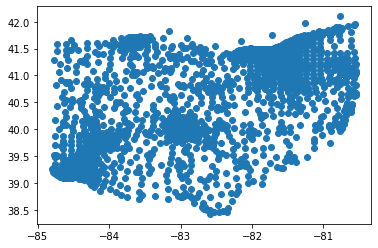

In [9]:
plt.scatter(centroids['centroidLng'], centroids['centroidLat'])

In [ ]:
# Functions to calculate the supermarkets within radius, as well as calculate the metrics from that list

def euc_dist(p1, p2x, p2y):
    # Calculating the euclidean distance between the coordinates.
    # Have to have p2 separated because apply function is dumb >:(
    return math.sqrt((p1[0] - p2x) ** 2 + (p1[1] - p2y) ** 2)

def milesToCoordinates(miles):
    # Converting miles to coordinate distances.
    # The true conversion is much more complicated and depends
    # a lot on longitude, but that's life baybay.
    # 45 is based on average longitude of Ohio
    return dist / 45

def getAvgDistBetweenSupermarkets(df):
    # Calculate the average value of the distance
    # between every combination of supermarkets
    # within the dataframe
    combos = combinations(df['location'], 2)
    distances = [euc_dist(p1, p2[0], p2[1]) for p1, p2 in combos]
    if len(distances) == 0:
        return -1
    return sum(distances)/len(distances)

def getRegionQuality(centroid, supermarkets, radius):
    # Radius in miles
    
    # Finding the supermarkets within specified radius of origin centroid
    supermarketsWithinRange = supermarkets.loc[supermarkets['location'].apply(euc_dist, args = centroid) <= milesToCoordinates(radius)]
    supermarketsWithinRange['distance'] = supermarketsWithinRange['location'].apply(euc_dist, args = centroid)
    
    # Calculating metrics using the dataframe of supermarkets within range
    avgDist = getAvgDistBetweenSupermarkets(supermarketsWithinRange)
    primarySupermarketRate = supermarketsWithinRange['primaryTypeIsGrocery'].mean()
    optionsRating = supermarketsWithinRange['rating'].mean()
    
    return avgDist, primarySupermarketRate, optionsRating, len(supermarketsWithinRange)

In [ ]:
def generateRangeDF(radius):
    
    # Making copies of dataframes so we're not modifying the original
    tempCentroids = centroids.copy()
    tempSupermarkets = supermarkets.copy()
    tempOH = df2019OH.copy()

    # Calling getRegionQuality to generate the metrics and adding them as columns to the dataframe
    tempCentroids['temp_score'] = tempCentroids['centroid'].apply(getRegionQuality, args = (tempSupermarkets, radius))
    tempCentroids[['avg_intra_supermarket_dist','primary_term_supermarket_rate','avg_supermarket_rating', 'num_suppliers']] = pd.DataFrame(
        tempCentroids.temp_score.tolist(), index= tempCentroids.index
    )
    
    # Adding USDA data to the dataframe
    tempCentroids = tempCentroids.merge(tempOH[['CensusTract', 'Urban', 'Pop2010', 'OHU2010', 'TractHUNV', 'TractSNAP']], on = 'CensusTract')
    tempCentroids['no_vehicle_rate'] = tempCentroids['TractHUNV'] / tempCentroids['OHU2010']
    tempCentroids['persons_per_supplier'] = tempCentroids['Pop2010'] / tempCentroids['num_suppliers']
    tempCentroids['SNAP_rate'] = tempCentroids['TractSNAP'] / tempCentroids['Pop2010']
    
    return tempCentroids

In [ ]:
# Sample of how we consolidated our data.
# We used mile radii ranging from 0.5 - 15

"""
centroidshalfMile = generateRangeDF(0.5)
centroids1Mile = generateRangeDF(1)
centroids2halfMile = generateRangeDF(2.5)
centroids5Miles = generateRangeDF(5)
centroids10Miles = generateRangeDF(10)
centroids15Miles = generateRangeDF(15)
"""